# [Advanced] PySpark Know-How in Pratice 

## Tips to improve product engineering memory efficency by Partitioning

In this notebook, there would be a lot of advanced Spark Tips introduced that can be applied to boost the data processing. So Hang Tight! 

We all know that **Spark** is an **engine for parallel processing engine of data on nodes** 

Parallelism allows to perform millions tasks simultaneosly on numerous number of machines in a cluster independently. Under the hood, each dataframe (RDD) is stored in partitions on different cluster nodes. Partition basically is a logical chunk of a large distributed data set. 

It provides the possibility to distribute the work across the cluster, divide the task into smaller parts, and reduce memory requirements for each node. Partition is the main unit of parallelism in Apache Spark.

[Reference](https://luminousmen.com/)

In [1]:
#we use the findspark library to locate spark on our local machine
import findspark
findspark.init('C:/Users/bokhy/spark/spark-2.4.6-bin-hadoop2.7')

In [2]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import time

import pyspark # only run this after findspark.init()
from pyspark.sql import SparkSession, SQLContext
from pyspark.context import SparkContext
from pyspark.sql.functions import * 
from pyspark.sql.types import * 

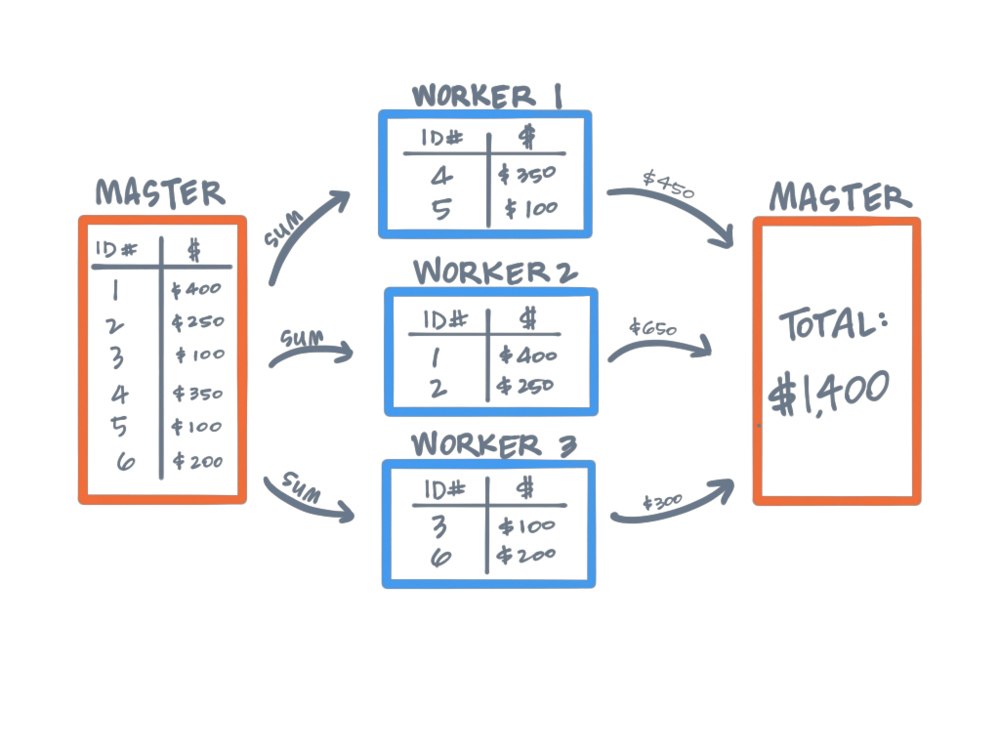

In [3]:
from IPython.display import Image
file_name1 = './img/sparkpartition.png'
Image(file_name1)

In [4]:
# Initiate the Spark Session
spark = SparkSession.builder.appName('example').getOrCreate()

In [5]:
spark

In [6]:
length = 100
names = np.random.choice(['Bob', 'James', 'Marek', 'Johannes', None], length)
amounts = np.random.randint(0, 1000000, length)
country = np.random.choice(
    ['United Kingdom', 'Poland', 'USA', 'Germany', None], 
    length
)
df = pd.DataFrame({'name': names, 'amount': amounts, 'country': country})

transactions = spark.createDataFrame(df)
print('Number of partitions: {}'.format(transactions.rdd.getNumPartitions()))
print('Partitioner: {}'.format(transactions.rdd.partitioner))
print('Partitions structure: {}'.format(transactions.rdd.glom().collect()))

Number of partitions: 8
Partitioner: None
Partitions structure: [[Row(name=None, amount=690431, country='Poland'), Row(name='Bob', amount=989205, country='USA'), Row(name=None, amount=749124, country='USA'), Row(name='Bob', amount=390114, country='USA'), Row(name='Bob', amount=27101, country='Germany'), Row(name='Marek', amount=239455, country='Germany'), Row(name='Marek', amount=440177, country='Germany'), Row(name='Marek', amount=230251, country='Poland'), Row(name='Marek', amount=199096, country='United Kingdom'), Row(name='James', amount=601533, country='United Kingdom'), Row(name='James', amount=844170, country=None), Row(name='Johannes', amount=293551, country=None)], [Row(name='Marek', amount=319043, country=None), Row(name='Bob', amount=763421, country='Germany'), Row(name=None, amount=911897, country=None), Row(name='James', amount=728114, country='Germany'), Row(name=None, amount=587224, country='United Kingdom'), Row(name='Bob', amount=33331, country='USA'), Row(name='James'

#### we can see that our data is divided into four partitions (because my laptop has 8 cores and the spark created 8 executables in standalone mode), and if we apply the transformations on this data frame, the work of each partition will be done in a separate thread (and in my case on each individual processor core).

#### The most important reason is performance. By having all the data needed to calculate on a single node, we reduce the overhead on the shuffle (the need for serialization and network traffic).

#### The second reason is the cost reduction — better utilization of the cluster will help to reduce idle resources.

#### To solve these problems effectively, we need a mechanism to manage partitions.

## 1. Re-partitioning
The first way to manage partitions is repartition operation.

Under repartitioning meant the operation to reduce or increase the number of partitions in which the data in the cluster will be split. This process involves a **full shuffle**. Consequently, it is clear that repartitioning is an expensive process. In a typical scenario, most of the data should be serialized, moved, and deserialized.

In [9]:
repartitioned = transactions.repartition(4)
print('Number of partitions: {}'.format(repartitioned.rdd.getNumPartitions()))
print('Partitions structure: {}'.format(repartitioned.rdd.glom().collect()))

Number of partitions: 4
Partitions structure: [[Row(name='James', amount=601533, country='United Kingdom'), Row(name='Bob', amount=989205, country='USA'), Row(name='Marek', amount=199096, country='United Kingdom'), Row(name=None, amount=911897, country=None), Row(name='James', amount=525778, country='Poland'), Row(name=None, amount=959401, country=None), Row(name='James', amount=475125, country='USA'), Row(name='Johannes', amount=383020, country='United Kingdom'), Row(name='James', amount=56241, country='Germany'), Row(name=None, amount=176050, country='United Kingdom'), Row(name='James', amount=846487, country='United Kingdom'), Row(name='James', amount=543378, country='United Kingdom'), Row(name='Johannes', amount=926776, country='Germany'), Row(name='Marek', amount=365323, country=None), Row(name='Marek', amount=152771, country='Poland'), Row(name='Bob', amount=588214, country=None), Row(name='James', amount=697942, country='Germany'), Row(name='Marek', amount=321722, country=None),

#### We see that the number of partitions decreased to 4 and the data were reallocated by partitions.

#### In addition to specifying the number of partitions directly, you can pass in the name of the column by which you want to partition the data.

In [10]:
repartitioned = transactions.repartition('country')
print('Number of partitions: {}'.format(repartitioned.rdd.getNumPartitions()))
print('Partitions structure: {}'.format(repartitioned.rdd.glom().collect()))

Number of partitions: 200
Partitions structure: [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [Row(name='Bob', amount=27101, country='Germany'), Row(name='Marek', amount=239455, country='Germany'), Row(name='Marek', amount=440177, country='Germany'), Row(name='Bob', amount=763421, country='Germany'), Row(name='James', amount=728114, country='Germany'), Row(name='James', amount=56241, country='Germany'), Row(name='Johannes', amount=506203, country='Germany'), Row(name='Bob', amount=20803, country='Germany'), Row(name=None, amount=19308, country='Germany'), Row(name='Bob', amount=88516, country='Germany'), Row(name='Johannes', amount=219501, country='Germany'), Row(name='Johannes', amount=926776, country='Germany'), Row(name='Bob', amount=244974, country='Germany'), Row(name='Johannes', amount=856462, country='Germany'), Row(name='Bob', amount=490555, country='Germany'), Row(name='James', amount=697942, country='Germany'), Row(name='James', amou

#### We see that the number of partitions has become **200** and many of these partitions are completely empty. 

#### In this scenario, there are lots of cases when this operation will not be very useful and this method is only worth using when you clearly understand how it can speed up your Spark jobs.

## 2. Coalesce
The second way to manage partitions is **coalesce.**

This operation **reduces the number of partitions** and **avoids a full shuffle**. The executor can safely leave data on a minimum number of partitions, moving data only from redundant nodes. Therefore, it is better to use coalesce than repartition if you need to reduce the number of partitions.

However, you should understand that you can drastically reduce the parallelism of your data processing — coalesce is often pushed up further in the chain of transformation and can lead to fewer nodes for your processing than you would like. To avoid this, you can pass shuffle = true. 

This will add a shuffle step, but it also means that the reshuffled partitions will be using full cluster resources if possible.

In [11]:
coalesced = transactions.coalesce(2)
print('Number of partitions: {}'.format(coalesced.rdd.getNumPartitions()))
print('Partitions structure: {}'.format(coalesced.rdd.glom().collect()))

Number of partitions: 2
Partitions structure: [[Row(name=None, amount=690431, country='Poland'), Row(name='Bob', amount=989205, country='USA'), Row(name=None, amount=749124, country='USA'), Row(name='Bob', amount=390114, country='USA'), Row(name='Bob', amount=27101, country='Germany'), Row(name='Marek', amount=239455, country='Germany'), Row(name='Marek', amount=440177, country='Germany'), Row(name='Marek', amount=230251, country='Poland'), Row(name='Marek', amount=199096, country='United Kingdom'), Row(name='James', amount=601533, country='United Kingdom'), Row(name='James', amount=844170, country=None), Row(name='Johannes', amount=293551, country=None), Row(name='Marek', amount=319043, country=None), Row(name='Bob', amount=763421, country='Germany'), Row(name=None, amount=911897, country=None), Row(name='James', amount=728114, country='Germany'), Row(name=None, amount=587224, country='United Kingdom'), Row(name='Bob', amount=33331, country='USA'), Row(name='James', amount=525778, cou

## Layers of partitions
I would like to highlight the topic of Spark partitions on different layers of data processing. 

There are three stages at the physical level where the number of partitions is important. 
- input
- shuffle 
- output

Each of them is tweaked and managed differently. 

For example, at **input and output**, you can **control the size of a partition**, but at the **output**, I can also **control the number of files or the number of tasks by doing coalesce or repartition**. With shuffle, you can control the number of data that will move around the network.

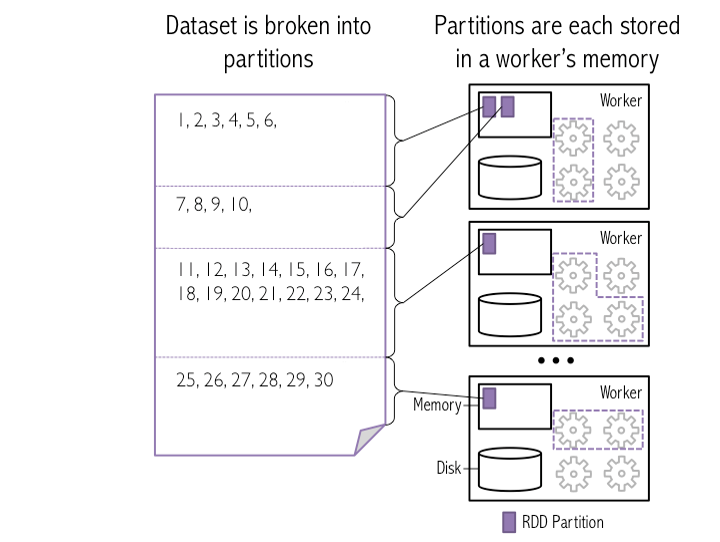

In [12]:
file_name2 = './img/input.png'
Image(file_name2)

### (1) Partitioning on input stage
Let's start by determining the number of partitions based on the size of the input dataset.

Spark can handle input pretty well as well as your data is explodable. There is a clear match between how data is placed in data storage such as HDFS or Cassandra and how Spark split the data while reading.

Let us imagine that the size of our input dataset is about 30 GB (~30000 MB) of an uncompressed text file on the HDFS which is distributing it on 10 nodes.

When Spark reads a file from HDFS, it creates a single partition for a single input split. Input split is set by the Hadoop InputFormat used to read this file. If you have a 30GB uncompressed text file stored on HDFS, then with the default HDFS block size setting (128MB) and default spark.files.maxPartitionBytes(128MB) it would be stored in 240 blocks, which means that the dataframe you read from this file would have 240 partitions.

This is equal to the Spark default parallelism (spark.default.parallelism) value.

If your data is not explodable then Spark will use the default number of partitions. When a job starts the number of partitions is equal to the total number of cores on all executor nodes.

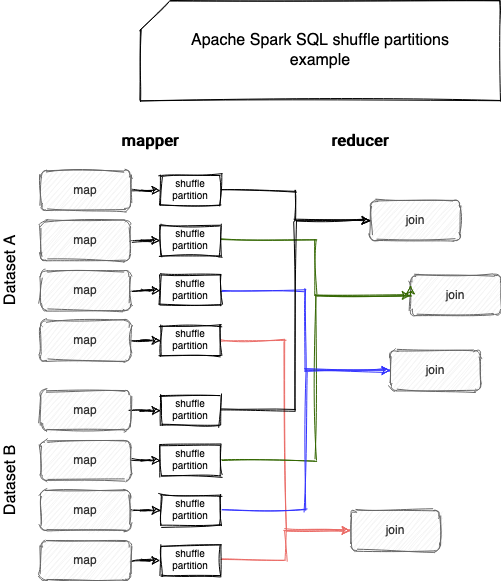

In [14]:
file_name3 = './img/shuffle.png'
Image(file_name3)

### (2) Shuffle partitioning
The most painful spot of any Spark pipeline is the wide transformations that require information from other partitions and trigger shuffle. Unfortunately, you can' t get rid of such transformations anyway but you can reduce shuffle impact on performance.

Shuffle partitions are partitions that are used at data shuffle for wide transformations. However, for wide transformations, the number of shuffle partitions is set to 200. It does not matter if your data is small or large, or if your cluster configuration has 20 executors, it is still 200. Yes, yes, that's what we saw in the repartition section, that's the mysterious number.

So the parameter that controls the parallelism that results from a shuffle is a parameter called spark.sql.shuffle.partitions.The reason why the default is 200 is from real-world experience that was found to be a very good default. But in practice, that value is usually always bad.

When dealing with small amounts of data, you should usually reduce the number of shuffle partitions otherwise you will end up with many partitions with small numbers of entries in each partition, which results in underutilization of all executors and increases the time it takes for data to be transferred over the network from the executor to the executor.

On the other hand, when you have too much data and too few partitions, it causes fewer tasks to be processed in executors, but it increases the load on each individual executor and often leads to memory errors. Also, if you increase the size of the partition larger than the available memory in the executor, you will get disk spills. Spills are the slowest thing you can probably be able to do. Essentially, during disk spills Spark operations place part of its RAM into a disk if it does not fit in memory, allowing Spark job to run well on any sized data. Even though it won't break your Pipeline it makes it super inefficient because of the additional overhead of disk I/O and increased garbage collection.

Therefore spark.sql.shuffle.partitions is one of the most frequently configured parameters when working with Spark.

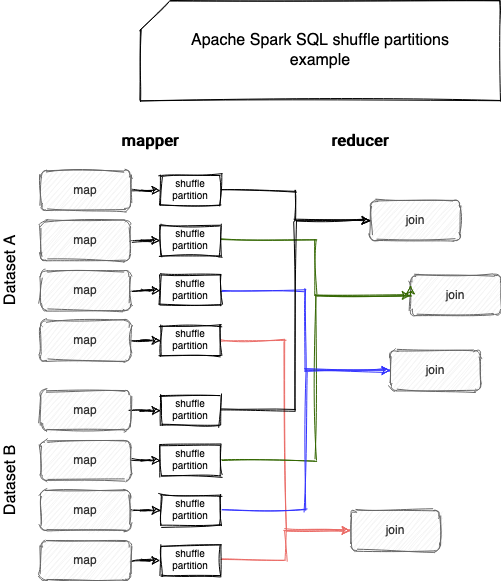

In [15]:
file_name4 = './img/shuffle.png'
Image(file_name4)

### (3) Output partitioning
Saving the partied data on the properly selected condition can significantly speed up the reading and retrieval of the necessary data in the future processing pipelines.

First, in some cases it is possible to use partition pruning after partition discovery of DataSource, it limits the number of files and partitions that Spark reads when querying. In some cases (for example AWS s3) it even avoids unnecessary partition discovery. It is also valuable with the concept of Dynamic Partition Pruning in Spark 3.0. But sometimes these optimizations can make things worse, e.g. recursive scanning of the file system for metadata to understand partitions for an initial query can take a long time(in case of a large number of partitions). Also, all table metadata must be materialized into the memory of the driver process and can significantly increase its memory burden.

Second, when saving DataFrame to disk, pay particular attention to partition sizes. During writing Spark will produce one file per task (i.e. one file per partition) and will read at least one file in the task while reading. The problem here is that if the cluster setup, in which DataFrame was saved, had more aggregate memory and thus could process large partitions sizes without any problems, then a smaller cluster may have problems with reading saved DataFrame.

For example, you have a large preprocessing cluster, and a smaller, more cost-effective service cluster. In this situation, the solution will be to repartition DataFrame into more partitions before writing, so that the next cluster will not get choked.

# Conclusion
- ### If you are increasing the number of partitions, Use **repartition()** (performing full shuffle)
- ### If you are decreasing the number of partitions, Use **coalesce()** (minimizes shuffles)

Reference:
https://luminousmen.com/